#PUI Midterm

## Goal: Assess whether the number of Units per zip code is a good predictor of citibike trips originating from that zip code.

## Notice: 
###Answer on likelihood ratio test part is wrong. The null hypothesis is that the simpler model, the line fit, is a better fit to the data

### the original denpendent variables are wrong. But the analysis process is correct, try to use the right variables.

## Import Environment

In [41]:
import pandas as pd 
import urllib2
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import pylab as pl
import statsmodels.formula.api as smf
import statsmodels.api as sm
s = json.load( open(os.getenv('PUI2015')+'/fbb_matplotlibrc.json') )
pl.rcParams.update(s)
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


## Step1: Collecting and Cleaning Data

### Read Raw Data
#### Notice: I use CSV file rather than SHP file

In [4]:
## Citi Bike Data
data_jan = pd.read_csv('201501-citibike-tripdata.csv')
data_may = pd.read_csv('201505-citibike-tripdata.csv')

##zipcode Data
url = 'http://cosmo.nyu.edu/~fb55/UI_CUSP_2015/data/stationzips.json'
request = urllib2.urlopen(url)
zipcode = json.loads(request.read())

##pluto Data
data_pluto = pd.read_csv('Mn.csv')

### Merge Zipcode and Res_Unit

#### read unitsres data

In [163]:
data_res = data_pluto[['ZipCode','UnitsRes']]
data_res = data_res.dropna()

#### groupby unitsres data

In [164]:
gb_res = data_res.groupby('ZipCode').sum()
gb_res.head()

,UnitsRes
ZipCode,
,0
10001,19703
10002,35386
10003,34025
10004,2409


#### transform to structure dataframe

In [165]:
list_zipcode = [] 
list_resu = []
for keys in gb_res['UnitsRes'].keys():
    list_zipcode.append(keys)
    list_resu.append(gb_res['UnitsRes'][keys])
## delete first item
list_zipcode=list_zipcode[1:len(list_zipcode)]
list_resu=list_resu[1:len(list_resu)]

In [166]:
dic = {'UnitsRes':list_resu,'Zipcode':list_zipcode}
zip_resu = pd.DataFrame(dic)

In [167]:
## print data 
zip_resu.head()

,UnitsRes,Zipcode
0,19703,10001
1,35386,10002
2,34025,10003
3,2409,10004
4,5567,10005


### Merge Zipcode and Citibike

In [168]:
data_jan['ZipCode'] = np.zeros(len(data_jan))
stids = np.unique(data_jan['start station id'])

In [169]:
for stid1 in stids:
    data_jan.loc[data_jan['start station id']==stid1,'ZipCode'] = zipcode[str(stid1)]
    data_may.loc[data_may['start station id']==stid1,'ZipCode'] = zipcode[str(stid1)]

#### Select Trip and Zipcode

In [170]:
data_newjan = data_jan[['tripduration','ZipCode']]
data_newmay = data_may[['tripduration','ZipCode']]

In [171]:
## print data
print data_newjan.head()

   tripduration  ZipCode
0          1346    10017
1           363    10011
2           346    10010
3           182    11238
4           969    10016


#### Concact Jan and May Data to mitigate seasonal effects

In [172]:
print len(data_newjan)
print len(data_newmay)

285552
961986


In [173]:
tripdata = [data_newjan,data_newmay]
tripdata = pd.concat(tripdata)

In [174]:
print len(tripdata)

1247538


#### groupby tripdata

In [175]:
gb_trip = tripdata.groupby('ZipCode').sum()
gb_trip.head()

,tripduration
ZipCode,
83,21770193
10001,77987012
10002,61976192
10003,102490494
10004,18201859


####transform to structure dataframe

In [176]:
list_zipcode = [] 
list_trip = []
for keys in gb_trip['tripduration'].keys():
    list_zipcode.append(str(int(keys)))
    list_trip.append(gb_trip['tripduration'][keys])

In [177]:
dic = {'Zipcode':list_zipcode,'Tripduration':list_trip}
zip_trip = pd.DataFrame(dic)

In [178]:
zip_trip.head()

,Tripduration,Zipcode
0,21770193,83
1,77987012,10001
2,61976192,10002
3,102490494,10003
4,18201859,10004


### Merge UnitsRes, Tripduration by Zipcode

In [179]:
dataset= pd.merge(zip_trip,zip_resu,on=['Zipcode'])

In [180]:
dataset.head()

,Tripduration,Zipcode,UnitsRes
0,77987012,10001,19703
1,61976192,10002,35386
2,102490494,10003,34025
3,18201859,10004,2409
4,17429836,10005,5567


## Step2: Regression

### Fit Linear Regression

In [181]:
mod1 = smf.ols(formula='Tripduration ~ UnitsRes', data = dataset).fit()
mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Tripduration   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     15.55
Date:                Mon, 26 Oct 2015   Prob (F-statistic):           0.000743
Time:                        11:49:11   Log-Likelihood:                -420.02
No. Observations:                  23   AIC:                             844.0
Df Residuals:                      21   BIC:                             846.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   1.756e+07   7.98e+06      2.202      0.039      9.73e+05  3.41e+07
UnitsRes    1312.2621    332.750      3.944      0.001       620.272  2004.253
==============================================================================
Omnibus:                        4.155   Durbin-Watson:                   1.501
Prob(Omnibus):                  0.125   Jarque-Bera (JB):                2.362
Skew:                          -0.455   Prob(JB):                        0.307
Kurtosis:                       4.279   Cond. No.                     4.24e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.24e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

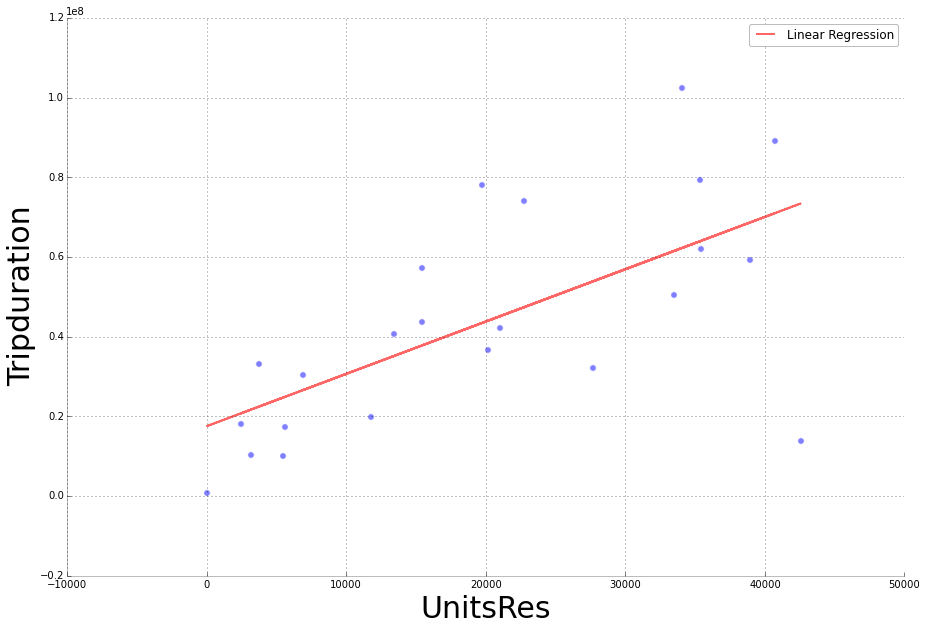

In [183]:
f = plt.figure(figsize=(15,10))
ax1 = plt.subplot(1,1,1) 
ax1.spines["top"].set_visible(False)  ## set the top frame invisible
ax1.spines["right"].set_visible(False) ## set the right frame invisible
ax1.get_xaxis().tick_bottom()  
ax1.get_yaxis().tick_left()  
plt.xlabel('UnitsRes',fontsize=30)
plt.ylabel('Tripduration',fontsize=30)
plt.scatter(dataset['UnitsRes'], dataset['Tripduration'],alpha=0.5,s=40)
plt.plot(dataset['UnitsRes'], mod1.predict(), color='red',alpha=0.6,label='Linear Regression')
plt.legend()

## Fit 2-degree polynomial Regression

In [184]:
mod2 = smf.ols(formula='Tripduration ~ UnitsRes + I(UnitsRes) + I(UnitsRes**2.0)', data = dataset).fit()
mod2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Tripduration   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     11.34
Date:                Mon, 26 Oct 2015   Prob (F-statistic):           0.000510
Time:                        11:49:25   Log-Likelihood:                -417.68
No. Observations:                  23   AIC:                             841.4
Df Residuals:                      20   BIC:                             844.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept           1.891e+06   1.04e+07      0.181      0.858     -1.99e+07  2.36e+07
UnitsRes            1928.3676    618.404      3.118      0.005       638.400  3218.335
I(UnitsRes)         1928.5841    617.413      3.124      0.005       640.683  3216.485
I(UnitsRes ** 2.0)    -0.0603      0.028     -2.126      0.046        -0.120    -0.001
==============================================================================
Omnibus:                        0.330   Durbin-Watson:                   1.554
Prob(Omnibus):                  0.848   Jarque-Bera (JB):                0.017
Skew:                          -0.066   Prob(JB):                        0.992
Kurtosis:                       2.984   Cond. No.                     9.35e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.78e-17. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

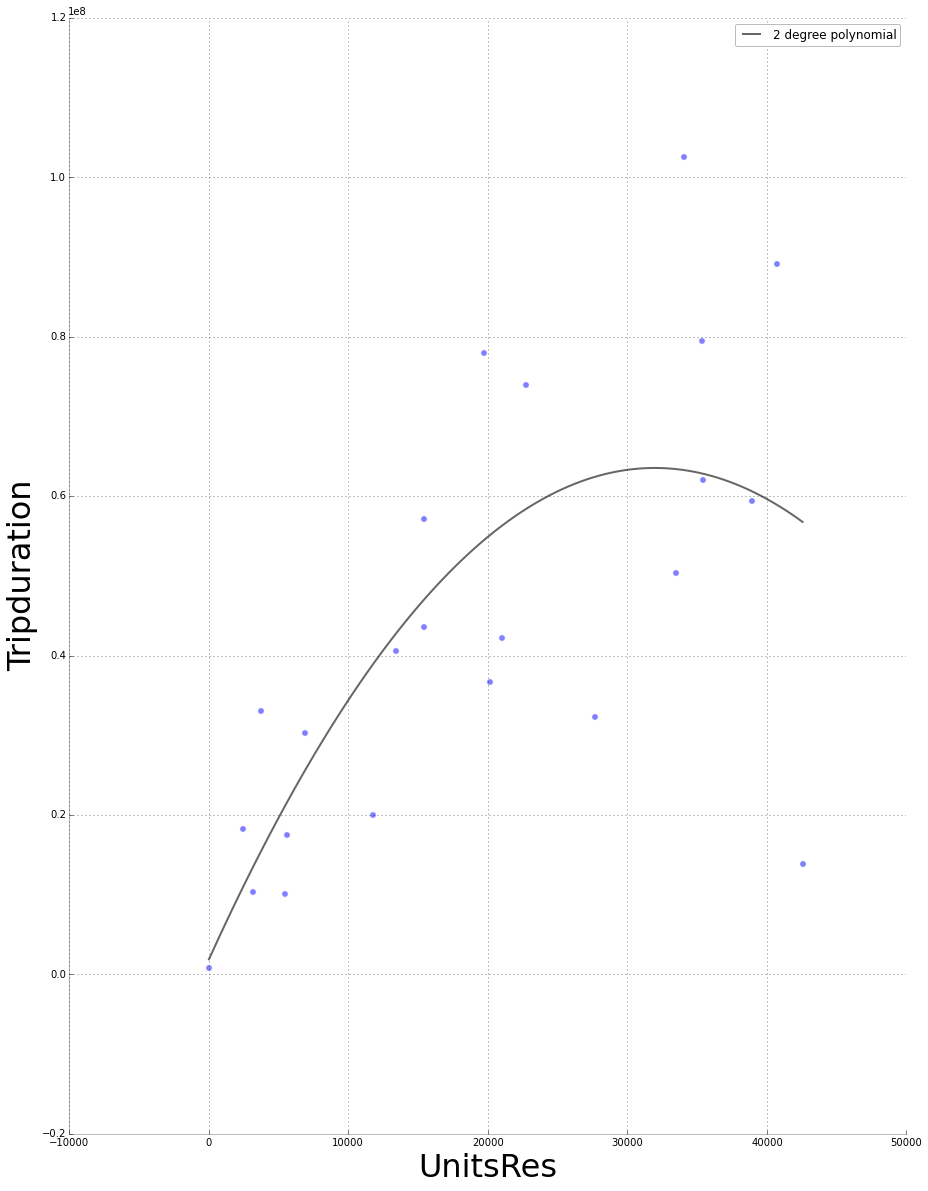

In [187]:
f = plt.figure(figsize=(15,20))
ax2 = plt.subplot(1,1,1)
ax2.spines["top"].set_visible(False)  ## set the top frame invisible
ax2.spines["right"].set_visible(False) ## set the right frame invisible
ax2.get_xaxis().tick_bottom()  
ax2.get_yaxis().tick_left()  
plt.xlabel('UnitsRes',fontsize=32)
plt.ylabel('Tripduration',fontsize=32)
x = np.linspace(min(dataset['UnitsRes']), max(dataset['UnitsRes']), 100)
xpd = pd.DataFrame({'UnitsRes':x})
plt.scatter(dataset['UnitsRes'], dataset['Tripduration'],alpha=0.5,s=40)
plt.plot(xpd, mod2.predict(xpd), color='k',alpha=0.6,label='2 degree polynomial')
plt.legend()

##Step3: Compare two models(Linear vs 2 Degree Polynomial)

In [188]:
print "LR : ", -2 * (mod1.llf - (mod2.llf))

LR :  4.68700847696


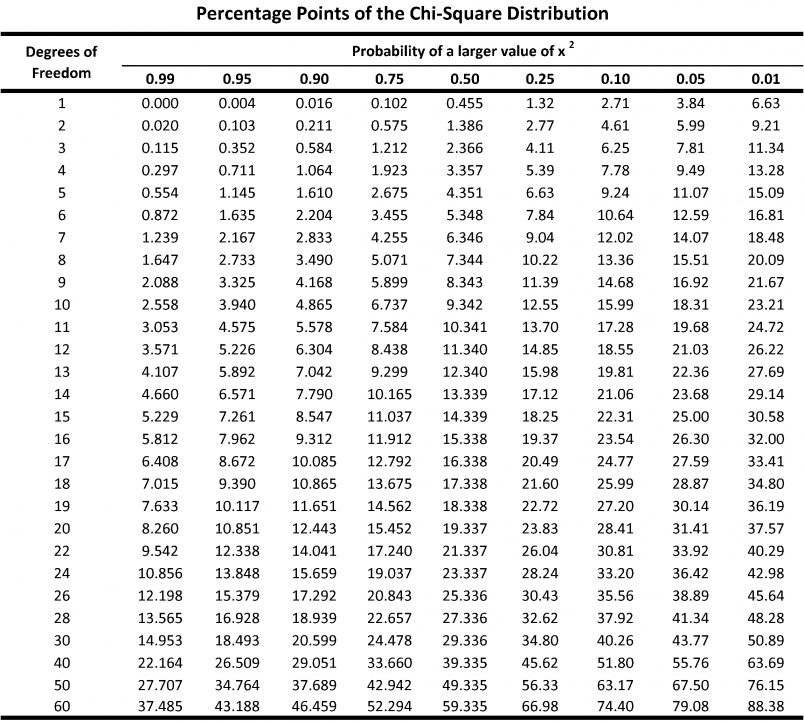

In [189]:
from IPython.display import Image
Image("http://passel.unl.edu/Image/Namuth-CovertDeana956176274/chi-sqaure%20distribution%20table.PNG")

###Comment:
- difference in parameters = chi2 DOF = 1
- the critical value for chi2 with 1 degree of freedom at alpha = 0.05 is 3.84
- Our chisq value(LR) is 4.68 larger than 3.84 
- Therefore, we reject null hypothesis which means 2 degree polynomial model is better. and the addition of the parameters is justified: we are NOT overfitting our data

##Step4: Regression without high leverage point

###Generate Influence Plot

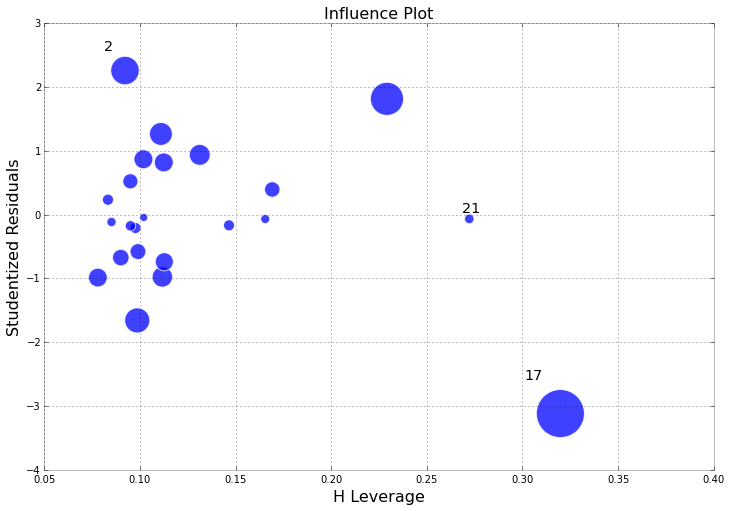

In [190]:
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(mod2,ax=ax,criterion="cooks")

###Fit Linear Regression

In [191]:
dataset2 = dataset.drop(dataset.index[[2,17,21]])

In [192]:
mod1 = smf.ols(formula='Tripduration ~ UnitsRes', data = dataset2).fit()
mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Tripduration   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     28.45
Date:                Mon, 26 Oct 2015   Prob (F-statistic):           4.53e-05
Time:                        11:50:02   Log-Likelihood:                -358.18
No. Observations:                  20   AIC:                             720.4
Df Residuals:                      18   BIC:                             722.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   1.642e+07   6.23e+06      2.636      0.017      3.33e+06  2.95e+07
UnitsRes    1467.9679    275.224      5.334      0.000       889.744  2046.192
==============================================================================
Omnibus:                        1.169   Durbin-Watson:                   1.690
Prob(Omnibus):                  0.557   Jarque-Bera (JB):                1.006
Skew:                           0.491   Prob(JB):                        0.605
Kurtosis:                       2.506   Cond. No.                     4.12e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.12e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

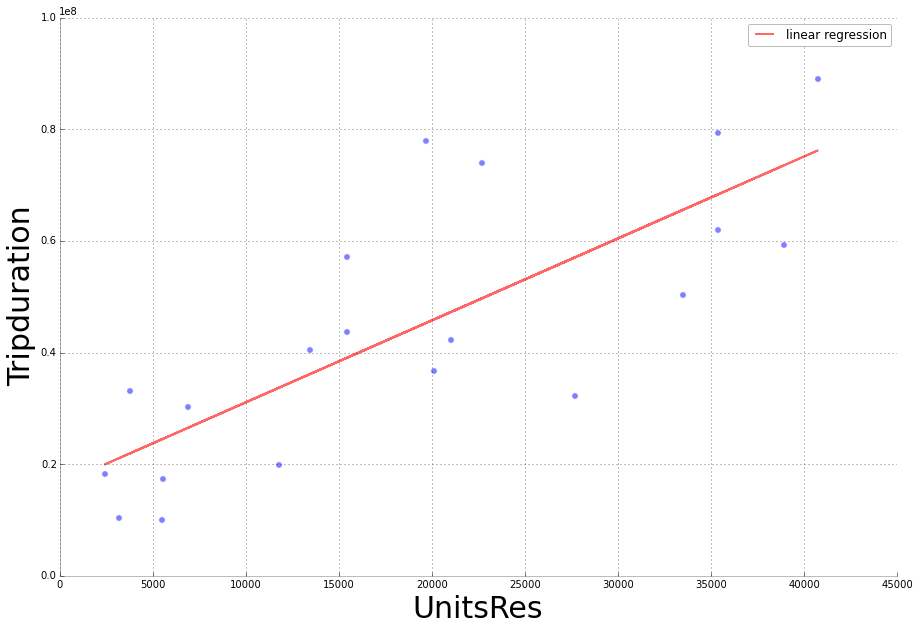

In [194]:
f = plt.figure(figsize=(15,10))
ax1 = plt.subplot(1,1,1) 
ax1.spines["top"].set_visible(False)  ## set the top frame invisible
ax1.spines["right"].set_visible(False) ## set the right frame invisible
ax1.get_xaxis().tick_bottom()  
ax1.get_yaxis().tick_left()  
plt.xlabel('UnitsRes',fontsize=30)
plt.ylabel('Tripduration',fontsize=30)
plt.scatter(dataset2['UnitsRes'], dataset2['Tripduration'],alpha=0.5,s=40)
plt.plot(dataset2['UnitsRes'], mod1.predict(), color='red',alpha=0.6,label='linear regression')
plt.legend()

### Fit 2-degree Polynomial Regression

In [195]:
mod2 = smf.ols(formula='Tripduration ~ UnitsRes + I(UnitsRes) + I(UnitsRes**2.0)', data = dataset2).fit()
mod2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Tripduration   R-squared:                       0.627
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                     14.29
Date:                Mon, 26 Oct 2015   Prob (F-statistic):           0.000229
Time:                        11:50:27   Log-Likelihood:                -357.80
No. Observations:                  20   AIC:                             721.6
Df Residuals:                      17   BIC:                             724.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept           1.043e+07   9.68e+06      1.078      0.296     -9.99e+06  3.09e+07
UnitsRes            1184.5229    570.733      2.075      0.053       -19.619  2388.664
I(UnitsRes)         1183.8846    571.248      2.072      0.054       -21.343  2389.113
I(UnitsRes ** 2.0)    -0.0216      0.027     -0.813      0.428        -0.078     0.034
==============================================================================
Omnibus:                        0.548   Durbin-Watson:                   1.803
Prob(Omnibus):                  0.760   Jarque-Bera (JB):                0.635
Skew:                           0.249   Prob(JB):                        0.728
Kurtosis:                       2.283   Cond. No.                     1.18e+20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.86e-22. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

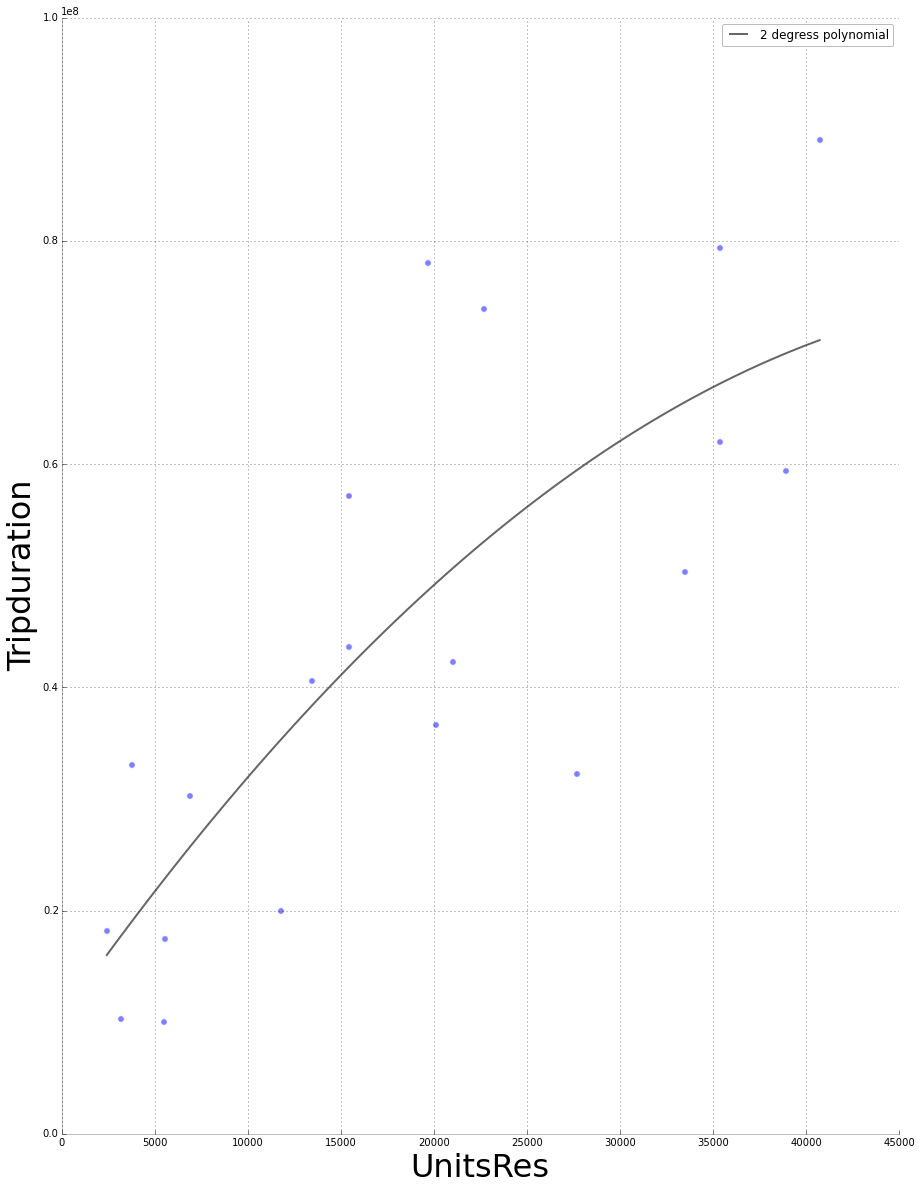

In [197]:
f = plt.figure(figsize=(15,20))
ax2 = plt.subplot(1,1,1)
ax2.spines["top"].set_visible(False)  ## set the top frame invisible
ax2.spines["right"].set_visible(False) ## set the right frame invisible
ax2.get_xaxis().tick_bottom()  
ax2.get_yaxis().tick_left()  
plt.xlabel('UnitsRes',fontsize=32)
plt.ylabel('Tripduration',fontsize=32)
x = np.linspace(min(dataset2['UnitsRes']), max(dataset2['UnitsRes']), 100)
xpd = pd.DataFrame({'UnitsRes':x})
plt.scatter(dataset2['UnitsRes'], dataset2['Tripduration'],alpha=0.5,s=40)
plt.plot(xpd, mod2.predict(xpd), color='k',alpha=0.6,label='2 degress polynomial')
plt.legend()

###Compare two models(Linear vs 2 Degree Polynomial)

In [198]:
print "LR : ", -2 * (mod1.llf - (mod2.llf))

LR :  0.762723783662


###Comment:
- difference in parameters = chi2 DOF = 1
- the critical value for chi2 with 1 degree of freedom at alpha = 0.05 is 3.84
- Our chisq value(LR) is 0.76 less than 3.84
- Therefore, we failed to reject null hypothesis which means 2 degree polynomial model is overfitting, linear model is better.

##Step5: Conclusion

### It seems like models which remove outliers are better than orignal model ($R^2$ is larger)
### I think the best model is the linear model which remove outliers
### For original part, 2 degree polynomial model is better than linear model
### maybe because it can fit those outliers but linear model can't 
### Therefore 2 degree polynomial didn't perform very well in remove outlier models.

##Step6: Discussion

#### We can find whether residential units may be a good predictor in weekend by restricting data only include saturday and sunday. 

##Extra Credit 1: Restrict by Weekend 

### Subset weekend data

In [200]:
data_jan['date'] = pd.to_datetime(data_jan['starttime'])
data_jan['weekday'] = data_jan['date'].dt.weekday
wkd_jan = data_jan[(data_jan['weekday']==5) | (data_jan['weekday']==6)]

In [201]:
data_may['date'] = pd.to_datetime(data_may['starttime'])
data_may['weekday'] = data_may['date'].dt.weekday
wkd_may = data_may[(data_may['weekday']==5) | (data_may['weekday']==6)]

In [202]:
wkddata = [wkd_jan,wkd_may]
wkddata = pd.concat(wkddata)

In [203]:
print len(wkd_jan)
print len(wkd_may)
print len(wkddata)

54570
258984
313554


In [204]:
tripdata = wkddata[['tripduration','ZipCode']]

In [205]:
tripdata.head()

,tripduration,ZipCode
16621,639,10003
16622,605,10016
16623,514,10019
16624,325,10003
16625,681,10017


In [206]:
gb_trip = tripdata.groupby('ZipCode').sum()
gb_trip.head()

,tripduration
ZipCode,
83,9595104
10001,17997508
10002,21073084
10003,29316079
10004,5185123


In [207]:
list_zipcode = [] 
list_trip = []
for keys in gb_trip['tripduration'].keys():
    list_zipcode.append(str(int(keys)))
    list_trip.append(gb_trip['tripduration'][keys])

In [208]:
dic = {'Zipcode':list_zipcode,'Tripduration':list_trip}
zip_trip = pd.DataFrame(dic)

In [209]:
zip_trip.head()

,Tripduration,Zipcode
0,9595104,83
1,17997508,10001
2,21073084,10002
3,29316079,10003
4,5185123,10004


### Merge UnitsRes, Tripduration by Zipcode

In [210]:
dataset= pd.merge(zip_trip,zip_resu,on=['Zipcode'])

In [211]:
dataset.head()

,Tripduration,Zipcode,UnitsRes
0,17997508,10001,19703
1,21073084,10002,35386
2,29316079,10003,34025
3,5185123,10004,2409
4,4151615,10005,5567


##Regression

### linear regression

In [230]:
mod1 = smf.ols(formula='Tripduration ~ UnitsRes', data = dataset).fit()
mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Tripduration   R-squared:                       0.444
Model:                            OLS   Adj. R-squared:                  0.417
Method:                 Least Squares   F-statistic:                     16.74
Date:                Mon, 26 Oct 2015   Prob (F-statistic):           0.000521
Time:                        12:02:43   Log-Likelihood:                -393.36
No. Observations:                  23   AIC:                             790.7
Df Residuals:                      21   BIC:                             793.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   4.038e+06    2.5e+06      1.614      0.122     -1.17e+06  9.24e+06
UnitsRes     427.2395    104.407      4.092      0.001       210.113   644.366
==============================================================================
Omnibus:                        1.232   Durbin-Watson:                   1.645
Prob(Omnibus):                  0.540   Jarque-Bera (JB):                0.292
Skew:                          -0.195   Prob(JB):                        0.864
Kurtosis:                       3.391   Cond. No.                     4.24e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.24e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

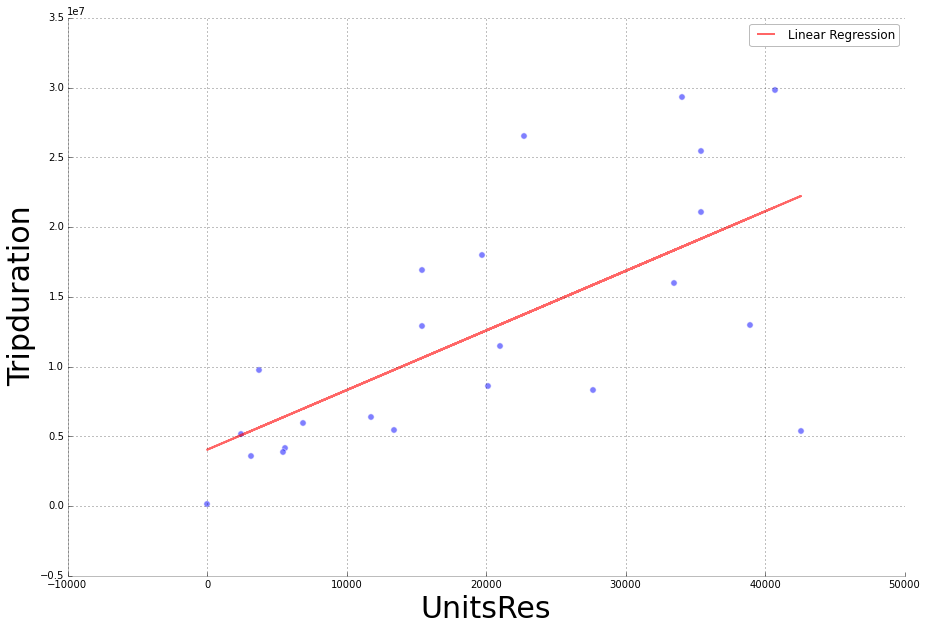

In [213]:
f = plt.figure(figsize=(15,10))
ax1 = plt.subplot(1,1,1) 
ax1.spines["top"].set_visible(False)  ## set the top frame invisible
ax1.spines["right"].set_visible(False) ## set the right frame invisible
ax1.get_xaxis().tick_bottom()  
ax1.get_yaxis().tick_left()  
plt.xlabel('UnitsRes',fontsize=30)
plt.ylabel('Tripduration',fontsize=30)
plt.scatter(dataset['UnitsRes'], dataset['Tripduration'],alpha=0.5,s=40)
plt.plot(dataset['UnitsRes'], mod1.predict(), color='red',alpha=0.6,label='Linear Regression')
plt.legend()

### 2 degree polynomial regression

In [217]:
mod2 = smf.ols(formula='Tripduration ~ UnitsRes + I(UnitsRes) + I(UnitsRes**2.0)', data = dataset).fit()
mod2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Tripduration   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     9.858
Date:                Mon, 26 Oct 2015   Prob (F-statistic):            0.00105
Time:                        11:57:00   Log-Likelihood:                -392.22
No. Observations:                  23   AIC:                             790.4
Df Residuals:                      20   BIC:                             793.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept           5.111e+05   3.45e+06      0.148      0.884     -6.68e+06   7.7e+06
UnitsRes             499.9891    204.403      2.446      0.024        73.611   926.367
I(UnitsRes)          500.0476    204.076      2.450      0.024        74.353   925.742
I(UnitsRes ** 2.0)    -0.0136      0.009     -1.448      0.163        -0.033     0.006
==============================================================================
Omnibus:                        0.025   Durbin-Watson:                   1.730
Prob(Omnibus):                  0.988   Jarque-Bera (JB):                0.213
Skew:                           0.054   Prob(JB):                        0.899
Kurtosis:                       2.541   Cond. No.                     9.35e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.78e-17. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

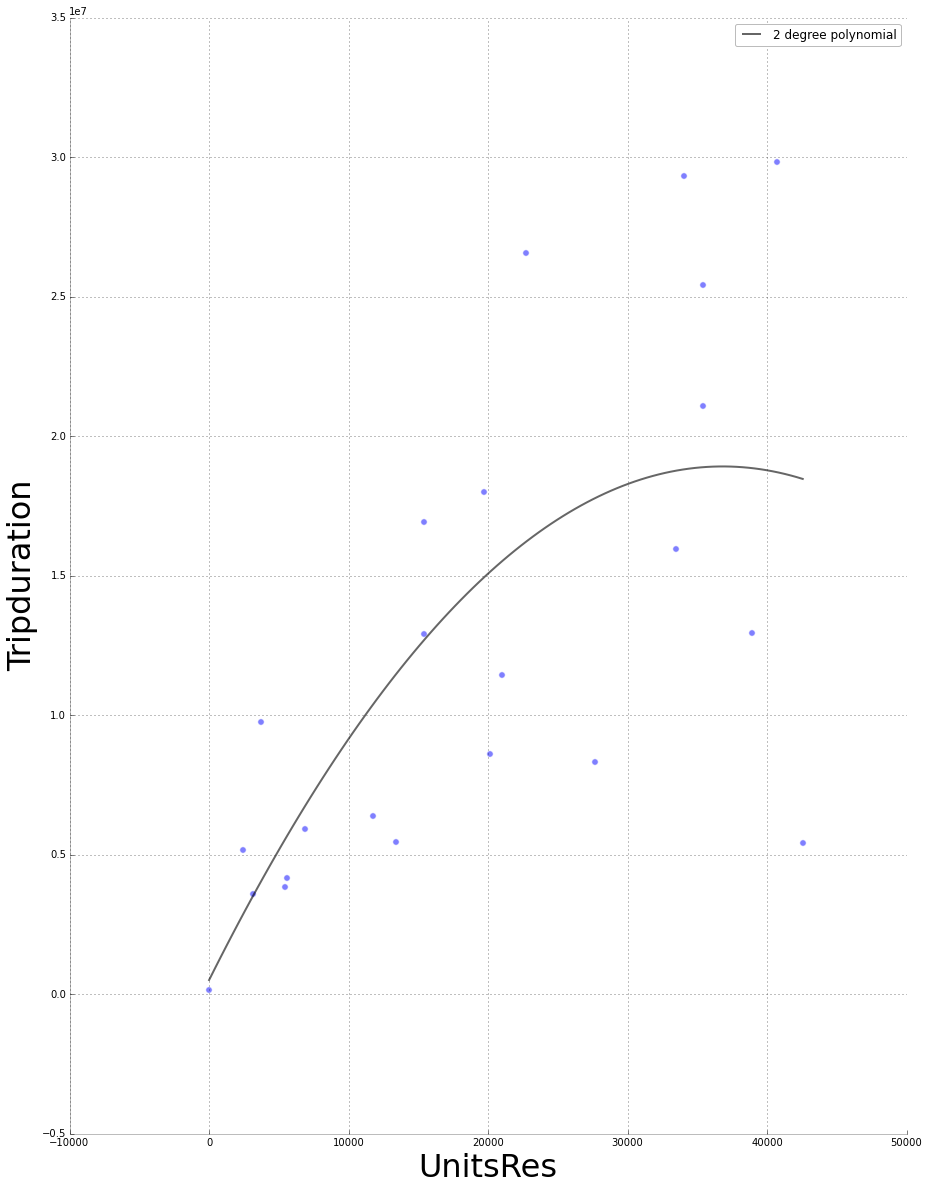

In [218]:
f = plt.figure(figsize=(15,20))
ax2 = plt.subplot(1,1,1)
ax2.spines["top"].set_visible(False)  ## set the top frame invisible
ax2.spines["right"].set_visible(False) ## set the right frame invisible
ax2.get_xaxis().tick_bottom()  
ax2.get_yaxis().tick_left()  
plt.xlabel('UnitsRes',fontsize=32)
plt.ylabel('Tripduration',fontsize=32)
x = np.linspace(min(dataset['UnitsRes']), max(dataset['UnitsRes']), 100)
xpd = pd.DataFrame({'UnitsRes':x})
plt.scatter(dataset['UnitsRes'], dataset['Tripduration'],alpha=0.5,s=40)
plt.plot(xpd, mod2.predict(xpd), color='k',alpha=0.6,label='2 degree polynomial')
plt.legend()

In [219]:
print "LR : ", -2 * (mod1.llf - (mod2.llf))

LR :  2.29282678733


####Comment:
The LR value showed that the linear regression is better.

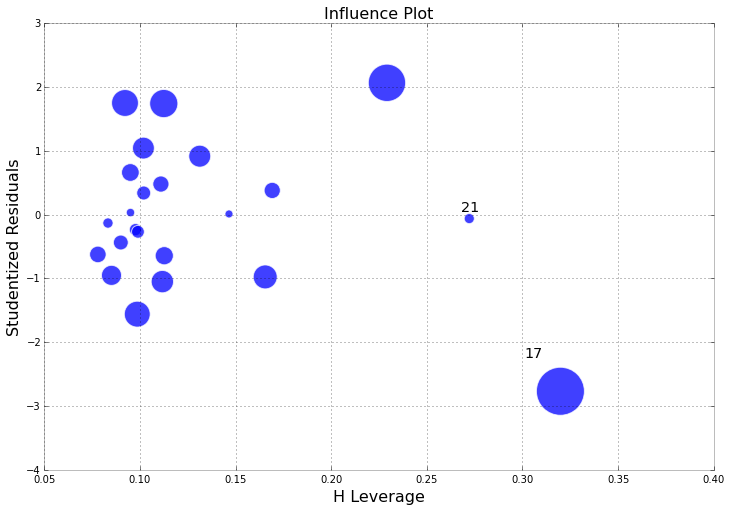

In [222]:
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(mod2,ax=ax,criterion="cooks")

In [223]:
dataset2 = dataset.drop(dataset.index[[17,21]])

In [224]:
mod1 = smf.ols(formula='Tripduration ~ UnitsRes', data = dataset2).fit()
mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Tripduration   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.570
Method:                 Least Squares   F-statistic:                     27.56
Date:                Mon, 26 Oct 2015   Prob (F-statistic):           4.56e-05
Time:                        11:59:37   Log-Likelihood:                -355.43
No. Observations:                  21   AIC:                             714.9
Df Residuals:                      19   BIC:                             717.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   3.186e+06   2.31e+06      1.378      0.184     -1.65e+06  8.02e+06
UnitsRes     520.7767     99.197      5.250      0.000       313.154   728.399
==============================================================================
Omnibus:                        0.070   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.966   Jarque-Bera (JB):                0.197
Skew:                           0.115   Prob(JB):                        0.906
Kurtosis:                       2.585   Cond. No.                     4.33e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.33e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

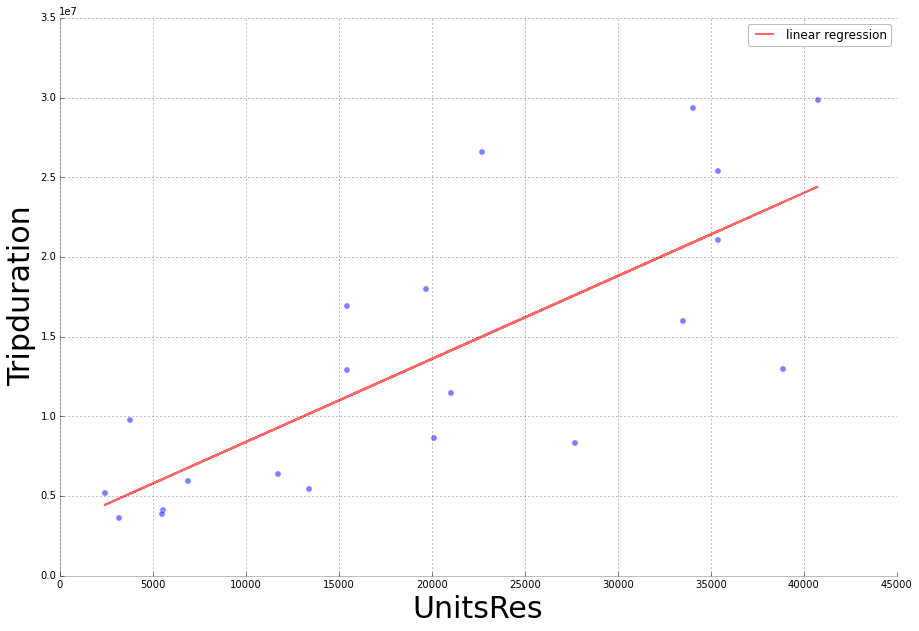

In [225]:
f = plt.figure(figsize=(15,10))
ax1 = plt.subplot(1,1,1) 
ax1.spines["top"].set_visible(False)  ## set the top frame invisible
ax1.spines["right"].set_visible(False) ## set the right frame invisible
ax1.get_xaxis().tick_bottom()  
ax1.get_yaxis().tick_left()  
plt.xlabel('UnitsRes',fontsize=30)
plt.ylabel('Tripduration',fontsize=30)
plt.scatter(dataset2['UnitsRes'], dataset2['Tripduration'],alpha=0.5,s=40)
plt.plot(dataset2['UnitsRes'], mod1.predict(), color='red',alpha=0.6,label='linear regression')
plt.legend()

In [226]:
mod2 = smf.ols(formula='Tripduration ~ UnitsRes + I(UnitsRes) + I(UnitsRes**2.0)', data = dataset).fit()
mod2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Tripduration   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     9.858
Date:                Mon, 26 Oct 2015   Prob (F-statistic):            0.00105
Time:                        12:00:12   Log-Likelihood:                -392.22
No. Observations:                  23   AIC:                             790.4
Df Residuals:                      20   BIC:                             793.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept           5.111e+05   3.45e+06      0.148      0.884     -6.68e+06   7.7e+06
UnitsRes             499.9891    204.403      2.446      0.024        73.611   926.367
I(UnitsRes)          500.0476    204.076      2.450      0.024        74.353   925.742
I(UnitsRes ** 2.0)    -0.0136      0.009     -1.448      0.163        -0.033     0.006
==============================================================================
Omnibus:                        0.025   Durbin-Watson:                   1.730
Prob(Omnibus):                  0.988   Jarque-Bera (JB):                0.213
Skew:                           0.054   Prob(JB):                        0.899
Kurtosis:                       2.541   Cond. No.                     9.35e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.78e-17. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

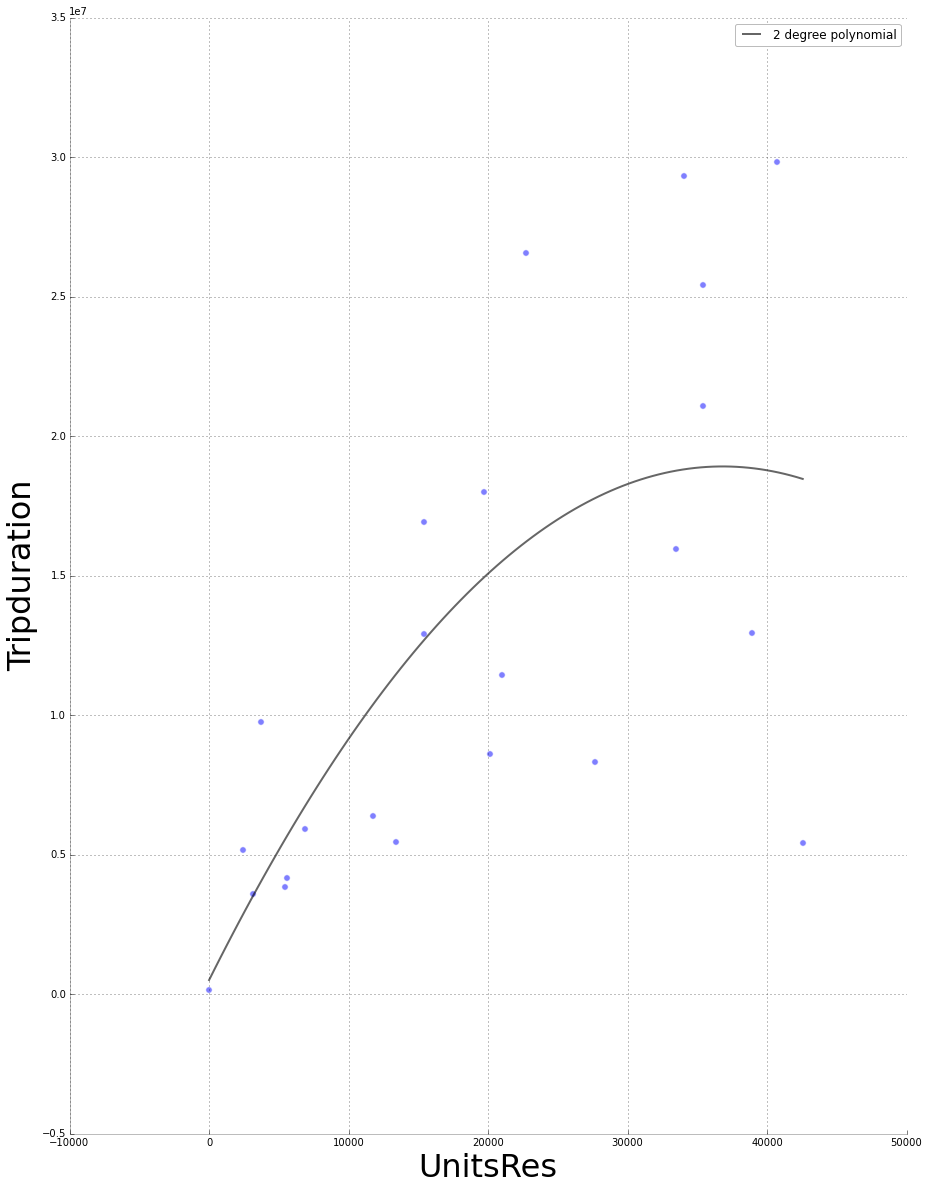

In [227]:
f = plt.figure(figsize=(15,20))
ax2 = plt.subplot(1,1,1)
ax2.spines["top"].set_visible(False)  ## set the top frame invisible
ax2.spines["right"].set_visible(False) ## set the right frame invisible
ax2.get_xaxis().tick_bottom()  
ax2.get_yaxis().tick_left()  
plt.xlabel('UnitsRes',fontsize=32)
plt.ylabel('Tripduration',fontsize=32)
x = np.linspace(min(dataset['UnitsRes']), max(dataset['UnitsRes']), 100)
xpd = pd.DataFrame({'UnitsRes':x})
plt.scatter(dataset['UnitsRes'], dataset['Tripduration'],alpha=0.5,s=40)
plt.plot(xpd, mod2.predict(xpd), color='k',alpha=0.6,label='2 degree polynomial')
plt.legend()

In [229]:
print "LR : ", -2 * (mod1.llf - (mod2.llf))

LR :  -73.5684082176


## Comment:
After remove high leveage point, the linear model is still better than polynomial model.
But compare to full dataset model, the $R^2$ is slightly less than full dataset model, basically there are not difference.

## Extra Credit 2: Using Other Variable(Age) as predictor

###Calculate Age

In [335]:
data_jan['age'] = 2015 - data_jan['birth year']
data_may['age'] = 2015 - data_may['birth year']

In [336]:
data_newjan = data_jan[['tripduration','age']]
data_newmay = data_may[['tripduration','age']]

In [337]:
print data_newjan.head()

   tripduration  age
0          1346   55
1           363   52
2           346   41
3           182   46
4           969   38


In [338]:
tripdata = [data_newjan,data_newmay]
tripdata = pd.concat(tripdata)

In [339]:
tripdata.head()

,tripduration,age
0,1346,55
1,363,52
2,346,41
3,182,46
4,969,38


###groupby by age and apply mean function

In [340]:
gb_trip = tripdata.groupby('age').sum()
gb_trip.head()

,tripduration
age,
16,167394
17,1015504
18,1416326
19,1763780
20,2832015


In [341]:
list_age = [] 
list_trip = []
for keys in gb_trip['tripduration'].keys():
    list_age.append(int(keys))
    list_trip.append(gb_trip['tripduration'][keys])

In [342]:
dic = {'Age':list_age,'Tripduration':list_trip}
age_trip = pd.DataFrame(dic)

In [343]:
age_trip.head()

,Age,Tripduration
0,16,167394
1,17,1015504
2,18,1416326
3,19,1763780
4,20,2832015


In [344]:
dataset = age_trip

In [345]:
mod1 = smf.ols(formula='Tripduration ~ Age', data = dataset).fit()
mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Tripduration   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     54.98
Date:                Mon, 26 Oct 2015   Prob (F-statistic):           1.27e-10
Time:                        12:57:54   Log-Likelihood:                -1387.7
No. Observations:                  80   AIC:                             2779.
Df Residuals:                      78   BIC:                             2784.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   2.532e+07   2.23e+06     11.344      0.000      2.09e+07  2.98e+07
Age        -2.626e+05   3.54e+04     -7.415      0.000     -3.33e+05 -1.92e+05
==============================================================================
Omnibus:                        2.600   Durbin-Watson:                   0.069
Prob(Omnibus):                  0.273   Jarque-Bera (JB):                1.982
Skew:                          -0.367   Prob(JB):                        0.371
Kurtosis:                       3.234   Cond. No.                         151.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

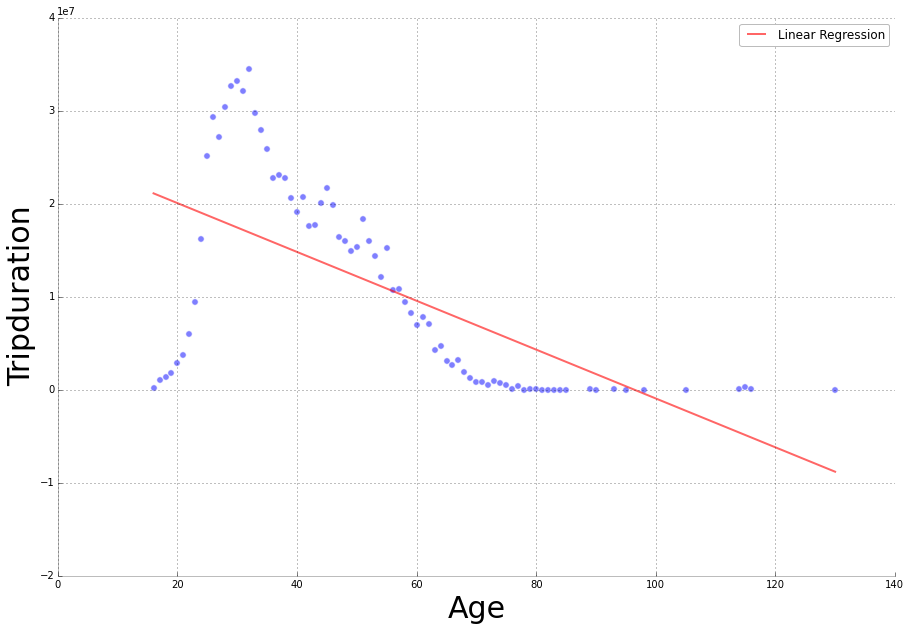

In [346]:
f = plt.figure(figsize=(15,10))
ax1 = plt.subplot(1,1,1) 
ax1.spines["top"].set_visible(False)  ## set the top frame invisible
ax1.spines["right"].set_visible(False) ## set the right frame invisible
ax1.get_xaxis().tick_bottom()  
ax1.get_yaxis().tick_left()  
plt.xlabel('Age',fontsize=30)
plt.ylabel('Tripduration',fontsize=30)
plt.scatter(dataset['Age'], dataset['Tripduration'],alpha=0.5,s=40)
plt.plot(dataset['Age'], mod1.predict(), color='red',alpha=0.6,label='Linear Regression')
plt.legend()

In [347]:
mod2 = smf.ols(formula='Tripduration ~ I(Age) + I(Age**2.0)', data = dataset).fit()
mod2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Tripduration   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                     27.19
Date:                Mon, 26 Oct 2015   Prob (F-statistic):           1.16e-09
Time:                        12:57:56   Log-Likelihood:                -1387.6
No. Observations:                  80   AIC:                             2781.
Df Residuals:                      77   BIC:                             2788.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept      2.436e+07   4.33e+06      5.622      0.000      1.57e+07   3.3e+07
I(Age)        -2.255e+05   1.47e+05     -1.535      0.129     -5.18e+05  6.71e+04
I(Age ** 2.0)  -291.0698   1121.279     -0.260      0.796     -2523.821  1941.682
==============================================================================
Omnibus:                        1.647   Durbin-Watson:                   0.070
Prob(Omnibus):                  0.439   Jarque-Bera (JB):                1.223
Skew:                          -0.298   Prob(JB):                        0.543
Kurtosis:                       3.111   Cond. No.                     2.43e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.43e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

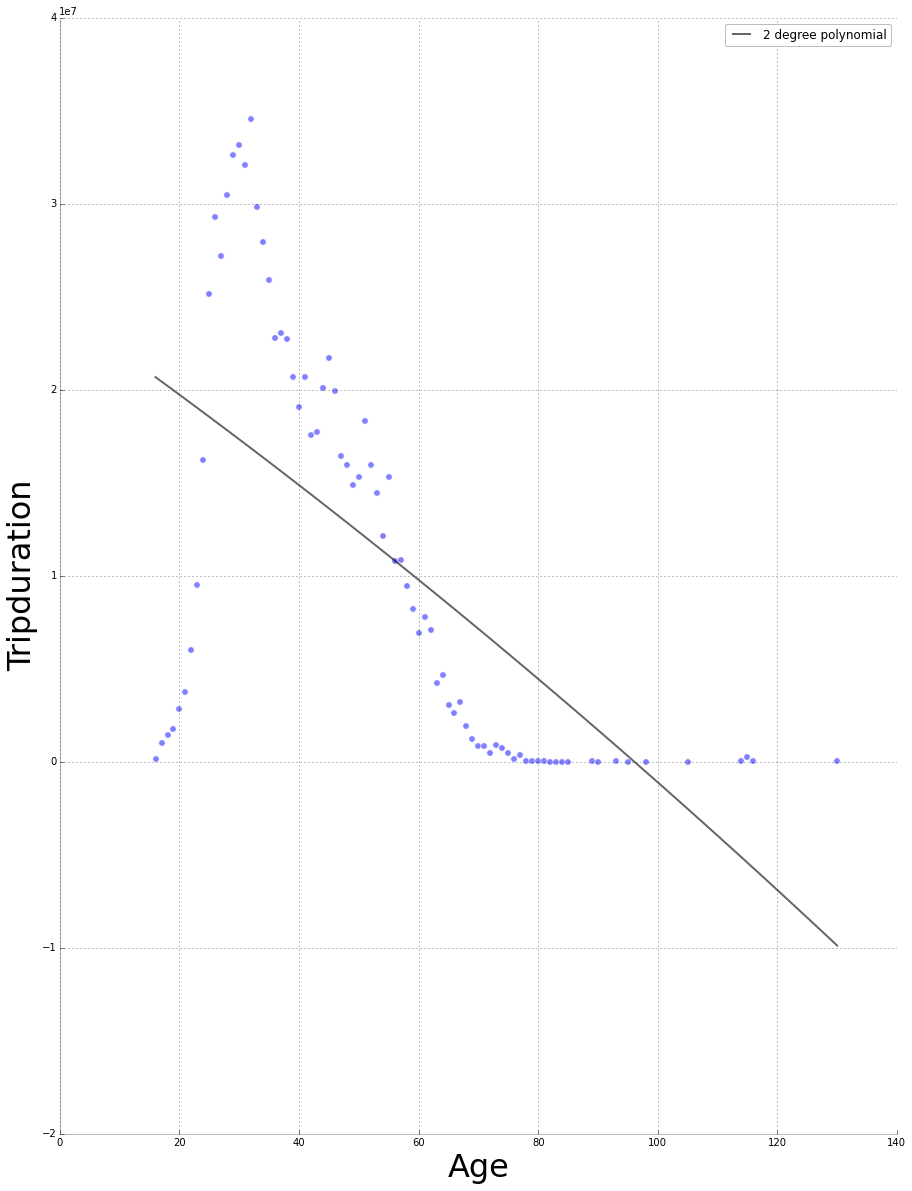

In [348]:
f = plt.figure(figsize=(15,20))
ax2 = plt.subplot(1,1,1)
ax2.spines["top"].set_visible(False)  ## set the top frame invisible
ax2.spines["right"].set_visible(False) ## set the right frame invisible
ax2.get_xaxis().tick_bottom()  
ax2.get_yaxis().tick_left()  
plt.xlabel('Age',fontsize=32)
plt.ylabel('Tripduration',fontsize=32)
x = np.linspace(min(dataset['Age']), max(dataset['Age']), 100)
xpd = pd.DataFrame({'Age':x})
plt.scatter(dataset['Age'], dataset['Tripduration'],alpha=0.5,s=40)
plt.plot(xpd, mod2.predict(xpd), color='k',alpha=0.6,label='2 degree polynomial')
plt.legend()

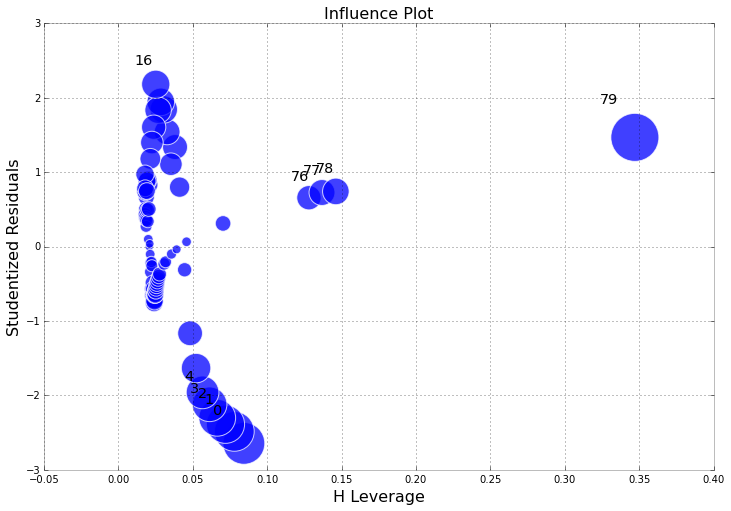

In [349]:
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(mod2,ax=ax,criterion="cooks")

## Comment:
It looks like age is not a good predictor, however may be we restrict the age under 70 can do better.

In [350]:
dataset = dataset[(dataset['Age']<70) & (dataset['Age']!=16)]

In [351]:
mod1 = smf.ols(formula='Tripduration ~ Age', data = dataset).fit()
mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Tripduration   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     8.984
Date:                Mon, 26 Oct 2015   Prob (F-statistic):            0.00420
Time:                        12:58:01   Log-Likelihood:                -924.44
No. Observations:                  53   AIC:                             1853.
Df Residuals:                      51   BIC:                             1857.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   2.616e+07    3.8e+06      6.885      0.000      1.85e+07  3.38e+07
Age        -2.496e+05   8.33e+04     -2.997      0.004     -4.17e+05 -8.24e+04
==============================================================================
Omnibus:                        3.216   Durbin-Watson:                   0.080
Prob(Omnibus):                  0.200   Jarque-Bera (JB):                2.879
Skew:                          -0.568   Prob(JB):                        0.237
Kurtosis:                       2.880   Cond. No.                         136.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [353]:
mod2 = smf.ols(formula='Tripduration ~ Age + I(Age) + I(Age**2.0)', data = dataset).fit()
mod2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Tripduration   R-squared:                       0.637
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     43.78
Date:                Mon, 26 Oct 2015   Prob (F-statistic):           1.03e-11
Time:                        12:58:15   Log-Likelihood:                -901.92
No. Observations:                  53   AIC:                             1810.
Df Residuals:                      50   BIC:                             1816.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept     -2.697e+07   6.96e+06     -3.874      0.000      -4.1e+07  -1.3e+07
Age             1.29e+06   1.75e+05      7.368      0.000      9.38e+05  1.64e+06
I(Age)          1.29e+06   1.75e+05      7.368      0.000      9.38e+05  1.64e+06
I(Age ** 2.0)  -3.29e+04   4020.538     -8.182      0.000      -4.1e+04 -2.48e+04
==============================================================================
Omnibus:                        4.894   Durbin-Watson:                   0.160
Prob(Omnibus):                  0.087   Jarque-Bera (JB):                4.778
Skew:                           0.696   Prob(JB):                       0.0917
Kurtosis:                       2.525   Cond. No.                     9.85e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.34e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

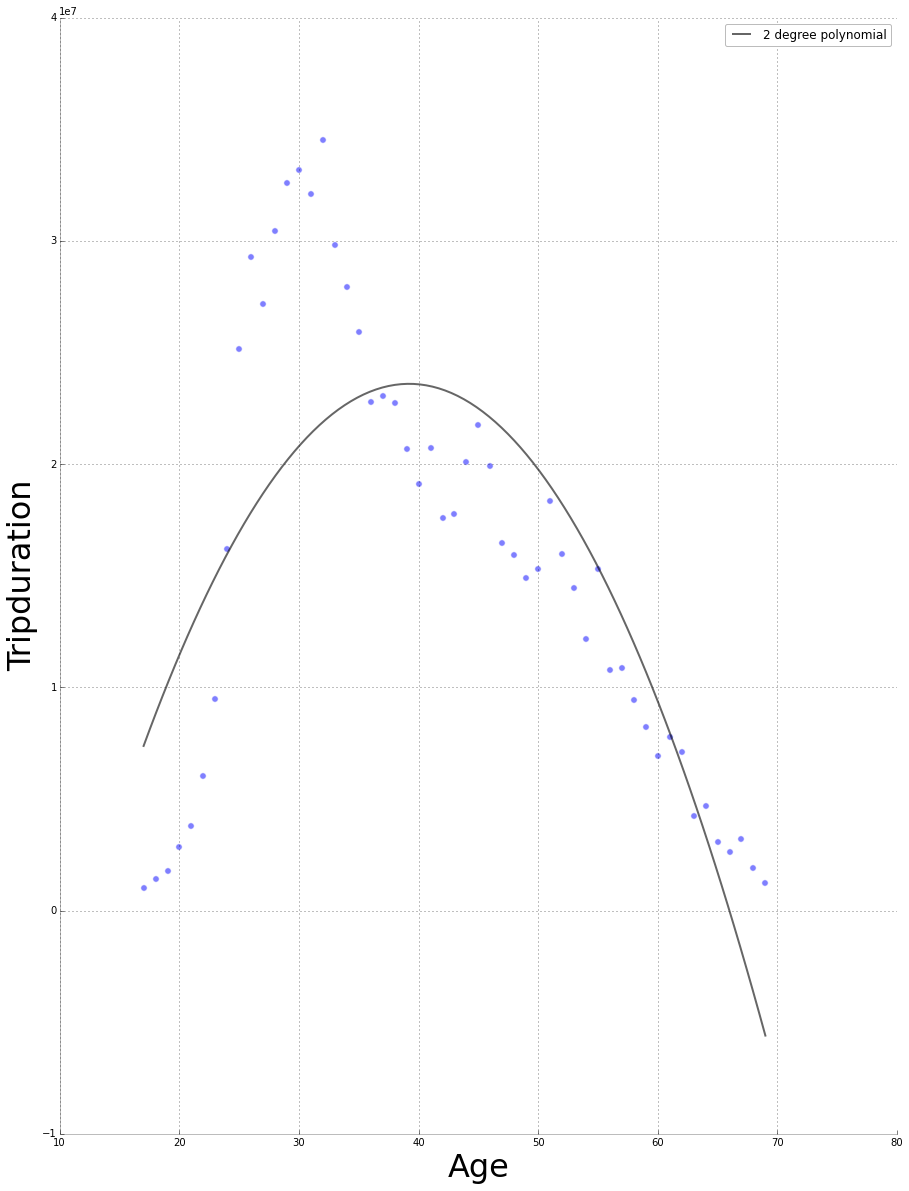

In [354]:
f = plt.figure(figsize=(15,20))
ax2 = plt.subplot(1,1,1)
ax2.spines["top"].set_visible(False)  ## set the top frame invisible
ax2.spines["right"].set_visible(False) ## set the right frame invisible
ax2.get_xaxis().tick_bottom()  
ax2.get_yaxis().tick_left()  
plt.xlabel('Age',fontsize=32)
plt.ylabel('Tripduration',fontsize=32)
x = np.linspace(min(dataset['Age']), max(dataset['Age']), 100)
xpd = pd.DataFrame({'Age':x})
plt.scatter(dataset['Age'], dataset['Tripduration'],alpha=0.5,s=40)
plt.plot(xpd, mod2.predict(xpd), color='k',alpha=0.6,label='2 degree polynomial')
plt.legend()

## Now we can say that the age predictor can use to predict tripduration if their age are under 70

## Extra Credit3: Brooklyn

In [334]:
data_pluto = pd.read_csv('BK.csv')

In [283]:
data_res = data_pluto[['ZipCode','UnitsRes']]
data_res = data_res.dropna()

##merge Zipcode and UnitsRes

In [284]:
gb_res = data_res.groupby('ZipCode').sum()
gb_res.head()

,UnitsRes
ZipCode,
11207,3681
11208,17400
11416,8
,36
11201,34527


In [316]:
list_zipcode = [] 
list_resu = []
for keys in gb_res['UnitsRes'].keys():
    list_zipcode.append(keys)
    list_resu.append(gb_res['UnitsRes'][keys])
## delete first item
list_zipcode=list_zipcode[1:len(list_zipcode)]
list_resu=list_resu[1:len(list_resu)]

In [317]:
dic = {'Zipcode':list_zipcode,'UnitsRes':list_resu}
zip_resu = pd.DataFrame(dic)

In [319]:
zip_resu = zip_resu.drop(zip_resu.index[[1,2,40]])

## Merge Zipcode and Trip

In [311]:
data_newjan = data_jan[['tripduration','ZipCode']]
data_newmay = data_may[['tripduration','ZipCode']]

In [312]:
tripdata = [data_newjan,data_newmay]
tripdata = pd.concat(tripdata)

In [313]:
gb_trip = tripdata.groupby('ZipCode').sum()

In [314]:
list_zipcode = [] 
list_trip = []
for keys in gb_trip['tripduration'].keys():
    list_zipcode.append(str(int(keys)))
    list_trip.append(gb_trip['tripduration'][keys])

In [315]:
dic = {'Zipcode':list_zipcode,'Tripduration':list_trip}
zip_trip = pd.DataFrame(dic)

## Merge Zipcode Trip UnitsResi

In [321]:
dataset= pd.merge(zip_trip,zip_resu,on=['Zipcode'])

In [332]:
dataset

,Tripduration,Zipcode,UnitsRes
0,55376378,11201,34527
1,14011238,11205,18060
2,24843615,11211,29040
3,2481113,11216,25241
4,14428607,11217,19614
5,6656009,11238,27504


In [324]:
mod1 = smf.ols(formula='Tripduration ~ UnitsRes', data = dataset).fit()
mod1.summary()

/Users/luke/anaconda/lib/python2.7/site-packages/statsmodels/stats/stattools.py:72: UserWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  "samples were given." % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Tripduration   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     3.243
Date:                Mon, 26 Oct 2015   Prob (F-statistic):              0.146
Time:                        12:49:41   Log-Likelihood:                -106.78
No. Observations:                   6   AIC:                             217.6
Df Residuals:                       4   BIC:                             217.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   -3.39e+07   3.04e+07     -1.114      0.328     -1.18e+08  5.06e+07
UnitsRes    2085.7765   1158.189      1.801      0.146     -1129.872  5301.425
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.538
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.604
Skew:                          -0.187   Prob(JB):                        0.739
Kurtosis:                       1.491   Cond. No.                     1.23e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.23e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

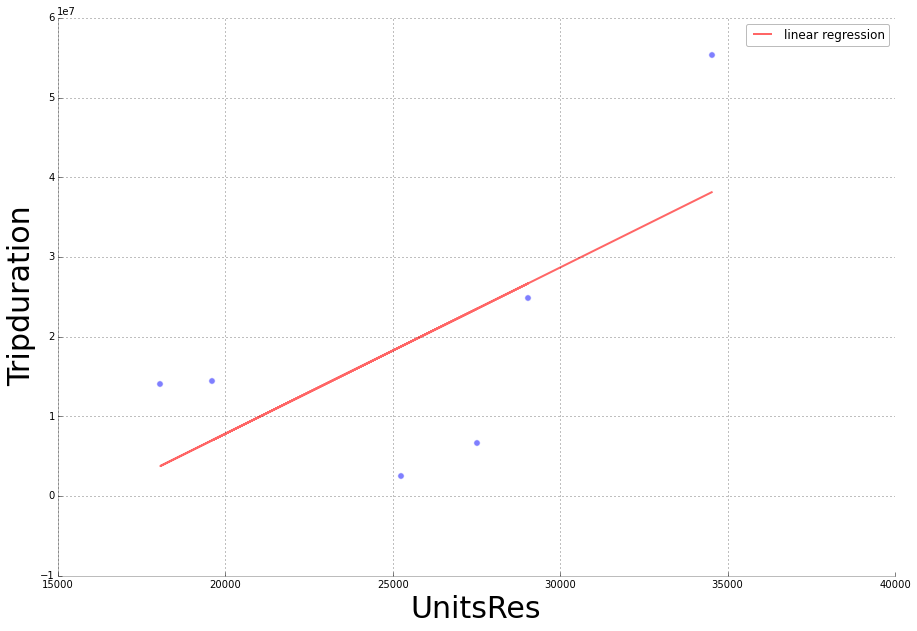

In [326]:
f = plt.figure(figsize=(15,10))
ax1 = plt.subplot(1,1,1) 
ax1.spines["top"].set_visible(False)  ## set the top frame invisible
ax1.spines["right"].set_visible(False) ## set the right frame invisible
ax1.get_xaxis().tick_bottom()  
ax1.get_yaxis().tick_left()  
plt.xlabel('UnitsRes',fontsize=30)
plt.ylabel('Tripduration',fontsize=30)
plt.scatter(dataset['UnitsRes'], dataset['Tripduration'],alpha=0.5,s=40)
plt.plot(dataset['UnitsRes'], mod1.predict(), color='red',alpha=0.6,label='linear regression')
plt.legend()

In [329]:
mod2 = smf.ols(formula='Tripduration ~ UnitsRes + I(UnitsRes) + I(UnitsRes**2.0)', data = dataset).fit()
mod2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Tripduration   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     24.05
Date:                Mon, 26 Oct 2015   Prob (F-statistic):             0.0142
Time:                        12:51:28   Log-Likelihood:                -100.06
No. Observations:                   6   AIC:                             206.1
Df Residuals:                       3   BIC:                             205.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept           2.351e+08   5.48e+07      4.292      0.023      6.07e+07  4.09e+08
UnitsRes           -9838.4818   2177.147     -4.519      0.020     -1.68e+04 -2909.829
I(UnitsRes)        -9885.0265   2187.921     -4.518      0.020     -1.68e+04 -2922.086
I(UnitsRes ** 2.0)     0.4214      0.084      5.021      0.015         0.154     0.689
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   3.081
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.728
Skew:                           0.633   Prob(JB):                        0.695
Kurtosis:                       1.856   Cond. No.                     4.39e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.75e-15. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

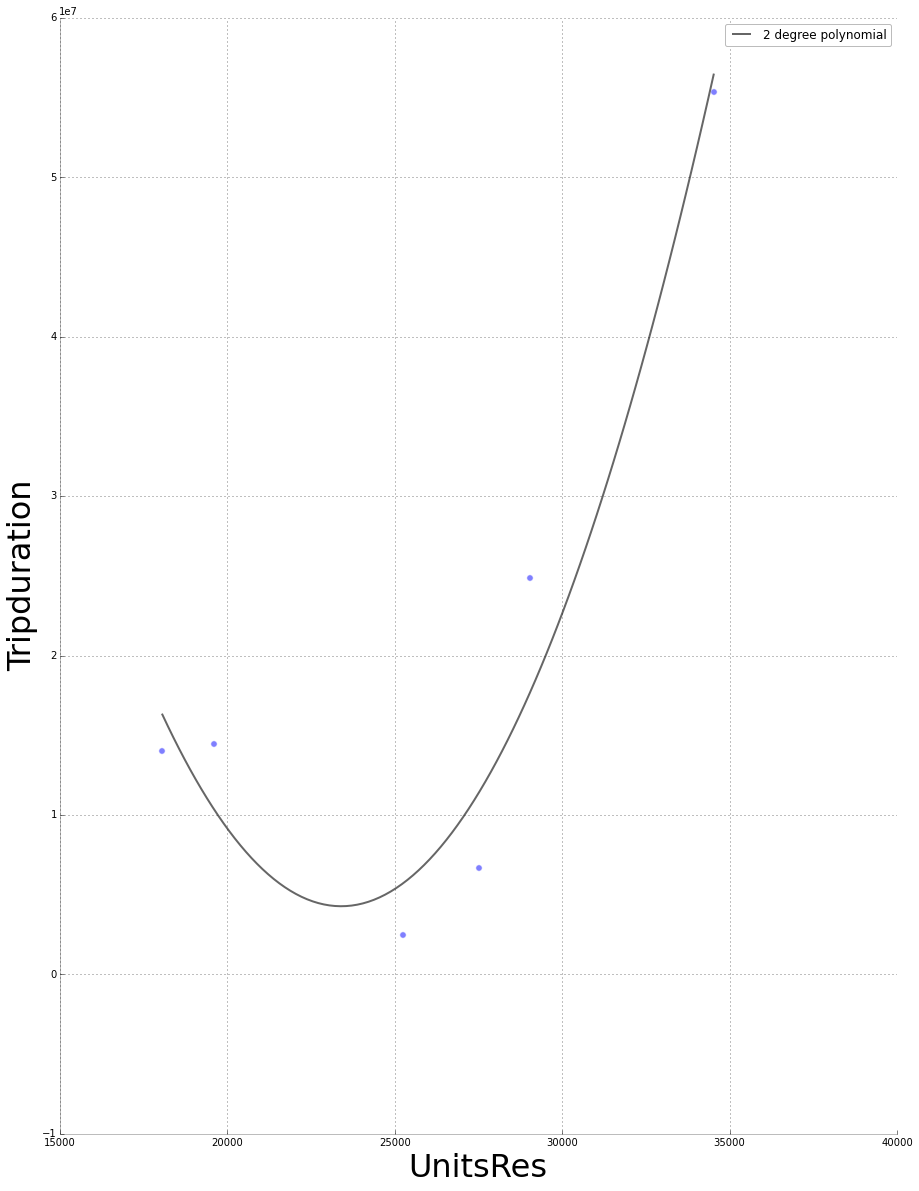

In [330]:
f = plt.figure(figsize=(15,20))
ax2 = plt.subplot(1,1,1)
ax2.spines["top"].set_visible(False)  ## set the top frame invisible
ax2.spines["right"].set_visible(False) ## set the right frame invisible
ax2.get_xaxis().tick_bottom()  
ax2.get_yaxis().tick_left()  
plt.xlabel('UnitsRes',fontsize=32)
plt.ylabel('Tripduration',fontsize=32)
x = np.linspace(min(dataset['UnitsRes']), max(dataset['UnitsRes']), 100)
xpd = pd.DataFrame({'UnitsRes':x})
plt.scatter(dataset['UnitsRes'], dataset['Tripduration'],alpha=0.5,s=40)
plt.plot(xpd, mod2.predict(xpd), color='k',alpha=0.6,label='2 degree polynomial')
plt.legend()

In [331]:
print "LR : ", -2 * (mod1.llf - (mod2.llf))

LR :  13.4474273959


## Comment:
The lr value is larger than 3.84 (critical value at dof=1), therefore we reject the null hypothesis which means polybinomial model is better